In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase
using NFFT
using CSV
using FHist
using Plots
using Random, Distributions, SpecialFunctions, LsqFit
using DifferentialEquations

In [88]:
function introduction(p, S; arr=1:100)
    q, r = rand(S), rand(arr,S)
    out = zeros(S)
    out[q .> p] .= r[q .> p]
    return out
end

function exp_growth(S, y0, Δt, n; σ=1.0, p=0.9)
    
    y = zeros(n,S)
    y[1,:] .= y0
    for i in 2:n
        gamma = abs.(1 .+ rand(Normal(0, σ), S))
        growth = y[i-1,:] .* exp.(gamma .* Δt)
        intro = introduction(p,S,arr=1:100)
        y[i,:] = growth .+ intro
    end

    return y
end

function logistic_growth(S, y0, Δt, n; r=1.0, K=ones(S), σ=1.0)
    # Logistic ODE
    function logistic!(du, u, p, t)
        r, K, σ = p
        du .= r .* u .* (1 .- u ./ K)
    end

    # Diffusion term (multiplicative noise)
    function diffusion!(du, u, p, t)
        σ = p[3]  # standard deviation of the noise
        du .= σ .* u  # multiplicative noise: noise scales with population
    end
        
    tspan = (0.0, n * Δt)
    p = (r, K, σ)
    
    prob = SDEProblem(logistic!, diffusion!, y0, tspan, p)
    sol = solve(prob, saveat=Δt)
    return reduce(hcat, sol.u)'
end

logistic_growth (generic function with 1 method)

In [79]:
# Random.seed!(1234)

# # Set parameters
# S = 5000
# y0 = ones(S)
# Δt = 0.1
# n = 4500
# r = 1.0
# K = 100 .* ones(S)
# noise_strength = 1.0

# # Simulate  dynamics
# y = logistic_growth(S, y0, Δt, n-1; r=r, K=K, σ=noise_strength)

# # Normalize entries
# y ./= sum(y, dims=2)

# # Save results into a DataFrame
# n, S = size(y)
# df = DataFrame(
#     time = repeat(1:n, inner=S),
#     variable = repeat(1:S, outer=n),
#     value = vec(permutedims(y)),
#     log_value = vec(permutedims(log10.(y)))
# )

# df_filtered = df[df.value .> 0.0, :];

In [116]:
Random.seed!(1234)

# Set parameters
S = 5000
y0 = 100 .* ones(S)
Δt = 0.1
n = 10000
p = 1

# Simulate  dynamics
y = exp_growth(S, y0, Δt, n; σ=0.5, p=p)

# Normalize entries
y ./= sum(y, dims=2)

# Save results into a DataFrame
n, S = size(y)
df = DataFrame(
    time = repeat(1:n, inner=S),
    variable = repeat(1:S, outer=n),
    value = vec(permutedims(y)),
    log_value = vec(permutedims(log10.(y)))
)

df_filtered = df[df.value .> 0.0, :];

6823
6823


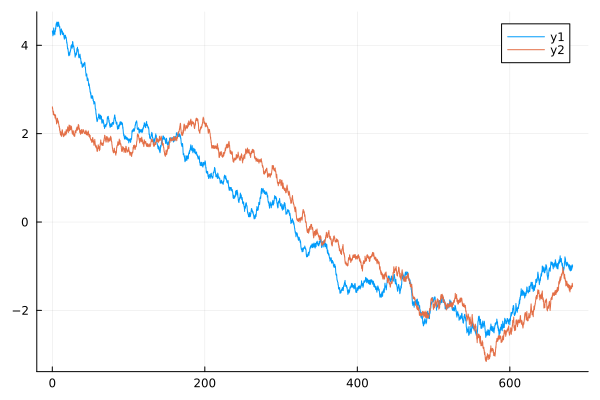

In [117]:
ddf = sort(df_filtered, :time);
idx1, idx2 = 1, 20

ts1 = ddf[ddf.variable .== ddf.variable[idx1],:].log_value
ts2 = ddf[ddf.variable .== ddf.variable[idx2],:].log_value

ts1 .-= mean(ts1)
ts2 .-= mean(ts2)

times1 = ddf[ddf.variable .== ddf.variable[idx1],:].time .* Δt
times2 = ddf[ddf.variable .== ddf.variable[idx2],:].time .* Δt

println(length(times1))
println(length(times2))

plot(times1, ts1)
plot!(times2, ts2)

In [118]:
function window_correction(window)
    # Helper function to avoid odd number of time steps which creates problems for FFT
    while (maximum(window) - minimum(window)) % 2 != 0
        if length(window) <= 1
            break  # Can't reduce further
        end
        window = window[1:end-1]  # Remove the last element
    end
    return window
end

function consecutive_window(data::Vector{<:Integer}, n::Integer = 0)
    if isempty(data)
        return Integer[]
    end
    out1 = [data[1]]
    out2 = Integer[]
    for (i, d) in enumerate(data[2:end])
        if d - out1[end] <= n + 1
            push!(out1, d)
        else
            out2 = consecutive_window(data[i+1:end], n)
            break
        end
    end
    return length(out1) >= length(out2) ? window_correction(out1) : window_correction(out2)
end

# Find the largest time window considering a maximum gap of 'daygap' days
daygap = 0
unique_days = unique(df_filtered.time)
sort!(unique_days)
window = consecutive_window(unique_days, daygap)
println(length(window))

# Filter to consider only rows with experiment_day in the selected window and reorder them
df_subset = filter(row -> in(row.time, window), df_filtered)
df_subset = df_subset[1:10:end, :]
sort!(df_subset, :time);

6823


In [113]:
# Set paramas and variables to perform NFFT
N = Int64(maximum(window) - minimum(window))
N_min = N / 2 # The analysis will consider only those species that are present in a 'sufficient' number of samples
fs = 1 / Δt
Nf = fs / 2 # Since sample rate is 1 day
frequencies = (-Int(floor(N/2)):Int(floor(N/2) - 1)) * fs / N # Frequency domain

println("Window length:  $N")

mean_S = zeros(N) # Initialize array
otu_count = 0 # Needed for normalization
otu_ids = unique(df_subset.variable)[1:200]
df_filtered = filter(:variable => in(otu_ids), df_subset)
grouped = groupby(df_filtered, :variable)

for otu in otu_ids
    group = grouped[otu]

    t_indices = collect(group.time)
    t_normalized = (t_indices .- minimum(window)) ./ N .- 0.5

    x = collect(group.log_value)
    x .-= mean(x)

    if length(t_indices) > N_min
        otu_count += 1
        p_nfft = NFFT.plan_nfft(t_normalized, N, reltol=1e-9)
        fhat = adjoint(p_nfft) * x

        S = abs2.(fhat) .* (Δt / N)
        mean_S .+= S
    end
end

println("OTUs considered:  $otu_count")

# Take only positive frequencies
positive = frequencies .> 0
frequencies = frequencies[positive]
mean_S = mean_S[positive] ./ otu_count;

Window length:  6822


LoadError: BoundsError: attempt to access 200-element Vector{Int64} at index [201]

In [114]:
# # Take logs
log_f = log10.(frequencies)
log_S = log10.(mean_S)

# Filter frequencies to avoid bias at too low and too high frequencies
# Essentially the fact the we have linear frequency binning but we compute the slope in log-log space creates problems
# at very low freqs because there are less points and at very high freqs because there are too many points. Moreover these
# methods are exact only in the infinite time case so we need to consider border effects.
mask = (log_f .> -1.3) .& (log_f .< 0.4)
log_f = log_f[mask]
log_S = log_S[mask]

# Put into a DataFrame and fit linear model: log_S ~ log_k
plot_df = DataFrame(log_f=log_f, log_S=log_S)
model = lm(@formula(log_S ~ log_f), plot_df)

# Extract the slope and intercept
coeffs = coef(model)
slope = coeffs[2]
intercept = coeffs[1]

println("Estimated slope: ", slope)
println("Intercept: ", intercept)

# Plot results
plot(log_f, log_S, label=:none, xlabel="log₁₀(frequency)", ylabel="log₁₀(power)", legend=:bottomleft,
    title="Mean PWD of most abundant species")
plot!(log_f, predict(model), label="Fit: slope = $(round(slope, digits=2))", lw=2)

LoadError: DomainError with -5.0:
log10 was called with a negative real argument but will only return a complex result if called with a complex argument. Try log10(Complex(x)).
DomainError detected in the user `f` function. This occurs when the domain of a function is violated.
For example, `log(-1.0)` is undefined because `log` of a real number is defined to only output real
numbers, but `log` of a negative number is complex valued and therefore Julia throws a DomainError
by default. Cases to be aware of include:

* `log(x)`, `sqrt(x)`, `cbrt(x)`, etc. where `x<0`
* `x^y` for `x<0` floating point `y` (example: `(-1.0)^(1/2) == im`)

Within the context of SciML, this error can occur within the solver process even if the domain constraint
would not be violated in the solution due to adaptivity. For example, an ODE solver or optimization
routine may check a step at `new_u` which violates the domain constraint, and if violated reject the
step and use a smaller `dt`. However, the throwing of this error will have halted the solving process.

Thus the recommended fix is to replace this function with the equivalent ones from NaNMath.jl
(https://github.com/JuliaMath/NaNMath.jl) which returns a NaN instead of an error. The solver will then
effectively use the NaN within the error control routines to reject the out of bounds step. Additionally,
one could perform a domain transformation on the variables so that such an issue does not occur in the
definition of `f`.

For more information, check out the following FAQ page:
https://docs.sciml.ai/Optimization/stable/API/FAQ/#The-Solver-Seems-to-Violate-Constraints-During-the-Optimization,-Causing-DomainErrors,-What-Can-I-Do-About-That?


In [94]:
# Consider only last point in time
# new_df = df_subset[df_subset.time .== maximum(df_subset.time), :]
# data = new_df.value
# log_data = new_df.log_value;

In [95]:
data = y[:,1]
log_data = log.(y[:,1]);

α = 1.3736080855031458
β = 2.2195530060219526
θ = 1.0990678982502968
s = 0.07790112819967324
s_th = -0.01285014357604812


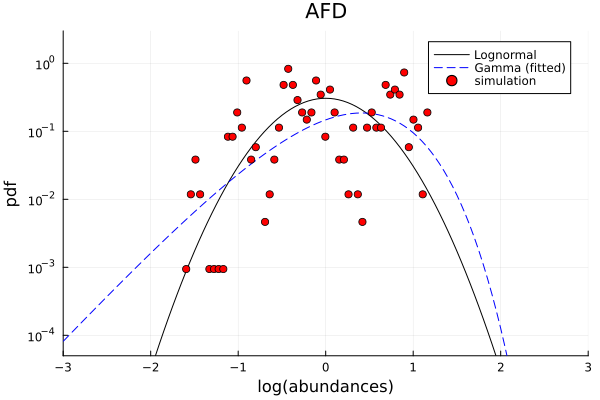

In [96]:
bmin = round(minimum(log_data), RoundFromZero)
bmax = round(maximum(log_data), RoundFromZero)
Δb = 0.05
fh = FHist.Hist1D(log_data, binedges=bmin:Δb:bmax)

# Renormalize the histogram and shift the centers
μ, σ = mean(fh), std(fh)
centers = bincenters(fh)
centers .-= μ
centers ./= sqrt(2 * σ^2)
norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
yy = [10^log(norm_counts[norm_counts.>0.0][i]) for i in eachindex(norm_counts[norm_counts.>0.0])]

centers = centers[norm_counts.>0.0]

# Plot the Gaussian distribution
xarr = -3.0:0.05:3.0
func = [10^(-x^2 - log(2 * π * σ^2) / 2) for x in xarr]
plot(xarr, func, color=:black, label="Lognormal", yscale=:log10, yrange=(5e-5, 3), xrange=(-3, 3),
    title="AFD", xlabel="log(abundances)", ylabel="pdf")

# Fit and plot gamma function
exp_gamma(x, p) = p[1] .* x .+ p[2] .* exp.(x) .+ p[3]
p0 = [1.0, 1.0, 1.0]  # Initial guess for the parameters
fit = curve_fit(exp_gamma, centers, log.(norm_counts[norm_counts.>0.0]), p0)
p_fit = fit.param

α, θ, s = p_fit[1], -1/p_fit[2], p_fit[3]
s_th = -(loggamma(α) + α * log(abs(θ))) / sqrt(2 * σ^2)
β = mean(data)^2 / var(data)
println("α = $α")
println("β = $β")
println("θ = $θ")
println("s = $s")
println("s_th = $s_th")

xarr = -3.0:0.05:3.0
fitted_y = exp_gamma(xarr, p_fit)
exp_fitted_y = [10^(fy) for fy in fitted_y]
plot!(xarr, exp_fitted_y, color=:blue, label="Gamma (fitted)", linestyle=:dash)

# Plot the collective histogram as a scatter plot
scatter!(centers, yy, color=:red, label="simulation")
# savefig("./Images/exp_growth.png")